We consider a utility maximization problem with the following model specifications: $L_M$, $L_F$ denotes hours worked by male and female respectively. $w_M$, $w_F$ is the wages for the workers. Hours worked at home are given by $H_M$, $H_F$. 

Consumption of market goods must satisfy the budget constraint, i.e.:

$$
C = w_ML_M+w_FL_f
$$

## Import of packages

In [2]:
# a. import
import ipywidgets as widgets
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import HouseholdSpecializationModel
from HouseholdSpecializationModel import HouseholdSpecializationModelClass
mo = HouseholdSpecializationModelClass()

## Question 1: Illustrate how $H_F/H_M$ changes when varying $\alpha$ and $\sigma$ 

In [3]:
# Define the values of alpha and sigma to use
alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1, 1.5]
mo = HouseholdSpecializationModelClass()
results_dict = {} # dictionary for storing the results

#Loop over all combinations of alpha and sigma values and find each solution
for alpha in alpha_values:
    for sigma in sigma_values:
        mo.par.alpha = alpha
        mo.par.sigma = sigma
        res = mo.solve_discrete()
        results_dict[alpha, sigma] = res.HF/ res.HM
        print(f'({alpha},{sigma}): z = {res.HF/res.HM:.3f}')

(0.25,0.5): z = 0.545
(0.25,1): z = 0.308
(0.25,1.5): z = 0.214
(0.5,0.5): z = 1.000
(0.5,1): z = 1.000
(0.5,1.5): z = 1.000
(0.75,0.5): z = 1.833
(0.75,1): z = 3.250
(0.75,1.5): z = 4.667


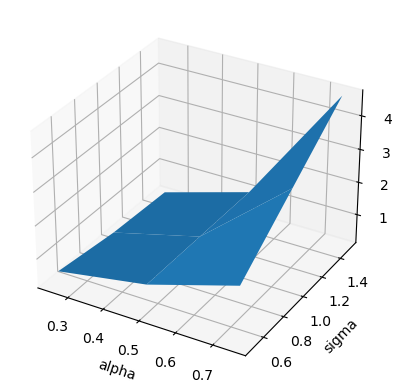

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# We plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Convert alpha and sigma values to a meshgrid for plotting
alpha_mesh, sigma_mesh = np.meshgrid(alpha_values, sigma_values)
z_mesh = np.array([results_dict[alpha, sigma] for alpha, sigma in zip(np.ravel(alpha_mesh), np.ravel(sigma_mesh))])
z_mesh = z_mesh.reshape(alpha_mesh.shape)

# Plot the surface
ax.plot_surface(alpha_mesh, sigma_mesh, z_mesh)
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('z')
plt.show()

## Question 2: plot $log H_F/H_M$ against $log w_F/w_M$ for $w_F \in [0.8, 0.9, 1, 1.1, 1.2]$


[0.22314355131420976, 0.0, 0.0, -0.11778303565638351, -0.2231435513142097]


Text(0, 0.5, 'log ($H_F$ / $H_M$)')

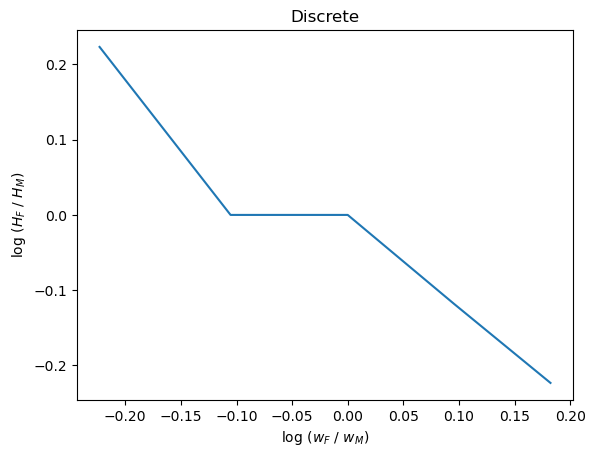

In [11]:
#Returner H relation for each value of wF
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
wM = 1.0
Log_ratio = []
wF_wM_c = np.empty(5)
import math
for wF in wF_values:
    mo.par.wF = wF
    mo.par.wM = wM
    opt = mo.solve_discrete()
    Log_ratio.append(math.log(opt.HF/opt.HM))
    wF_wM_c[i] = np.log(mo.par.wF/mo.par.wM)
print(Log_ratio)

# Plot H realtion against W relation 
plt.plot(np.log(wF_values), Log_ratio)
plt.title('Discrete')
plt.xlabel('log ($w_F$ / $w_M$)')
plt.ylabel('log ($H_F$ / $H_M$)')



## Question 3: Continously

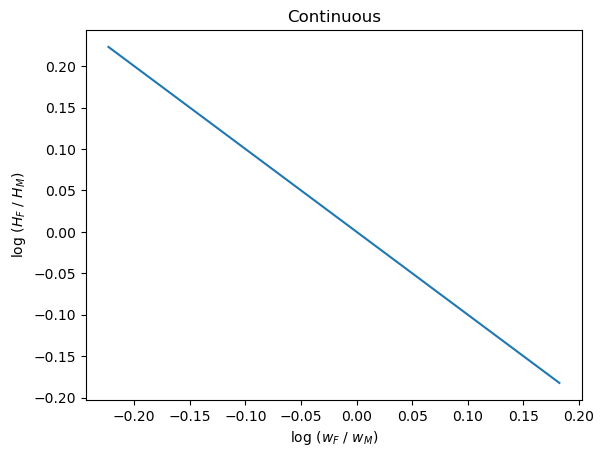

In [10]:
# Relation between WF and WM
mo.par.alpha = 0.5
mo.par.sigma = 1
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
HF_HM_c = np.empty(5)
wF_wM_c = np.empty(5)

#Continuous:
for i, wF in enumerate(mo.par.wF_vec):
    mo.par.wF = wF
    opt = mo.solve()

    HF_HM_c[i] = np.log(opt.HF/opt.HM)
    wF_wM_c[i] = np.log(mo.par.wF/mo.par.wM)
        
#Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Continuous')
ax.plot(wF_wM_c, HF_HM_c)
ax.set_xlabel("log ($w_F$ / $w_M$)")
ax.set_ylabel("log ($H_F$ / $H_M$)")
plt.show()


## Question 4: Choose $\alpha$ and $\sigma$ such that it minimizes $(\beta_0-\hat{\beta}_0)^2+(\beta_1-\hat{\beta}_1)^2$. Illustrate how the model fit the data and discuss the economic interpretation of the results. 

When alpha is equal to 0.982 and sigma is equal to 0.100, then the squared errors are minimized
Given these values, the beta coefficins are, beta0: 0.400 and beta1: -0.100.
With this the minimized squared error is then 0.000.


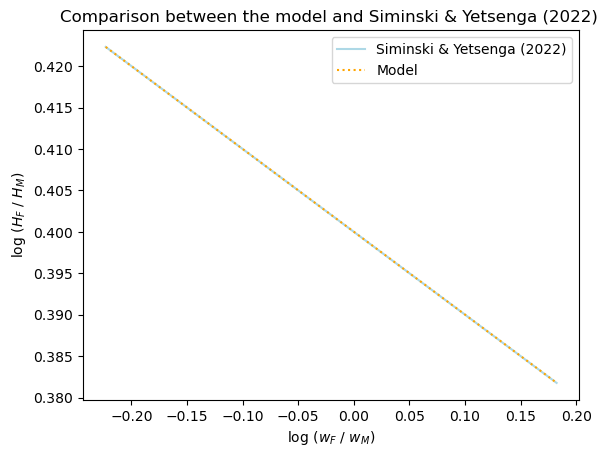

In [40]:
results = mo.estimate()
alpha = mo.par.alpha
sigma = mo.par.sigma
error = results.error
import matplotlib.pyplot as plt
import numpy as np

# b. print the solution, that minimizes the squared error
print(f'When alpha is equal to {mo.par.alpha:.3f} and sigma is equal to {mo.par.sigma:.3f}, then the squared errors are minimized')
print(f'Given these values, the beta coefficins are, beta0: {mo.sol.beta0:.3f} and beta1: {mo.sol.beta1:.3f}.') 
print(f'With this the minimized squared error is then {results.error:.3f}.') 


wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
HF_HM_c = np.empty(5)
wF_wM_c = np.empty(5)
reg_plot = np.empty(5)

for i, wF in enumerate(mo.par.wF_vec):
    mo.par.wF = wF
    opt = mo.solve()

    HF_HM_c[i] = np.log(opt.HF/opt.HM)
    wF_wM_c[i] = np.log(mo.par.wF/mo.par.wM)
    reg_plot[i] = 0.4 - 0.1*wF_wM_c[i]

#plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Comparison between the model and Siminski & Yetsenga (2022) ')
ax.plot(wF_wM_c, reg_plot, label = 'Siminski & Yetsenga (2022)', color="lightblue", linestyle= "-", alpha= 1)
ax.plot(wF_wM_c, HF_HM_c, label = 'Model', color = 'orange', linestyle = ':', alpha=1)
ax.set_xlabel("log ($w_F$ / $w_M$)")
ax.set_ylabel("log ($H_F$ / $H_M$)")
plt.legend()
plt.show()


## Question 5

In [41]:
# we start by resetting the epsilon-value
mo.par.epsilon = 1

# run baseline model
results = mo.estimation_extended(extended=False)


print(f'When alpha is equal to {mo.par.alpha} and sigma is equal to {float(mo.par.sigma):3f}, then the squared errors are minimized')
print(f'Given these values, the beta coefficins are, beta0: {mo.sol.beta0:.3f} and beta1: {mo.sol.beta1:.3f}.') 
print(f'With this the minimized squared error is then {results.error:.3f}.')

/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:68: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**sigma_ + (par.alpha)*HF**sigma_)**((sigma_)**-1)
/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:72: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


When alpha is equal to 0.5 and sigma is equal to 0.099707, then the squared errors are minimized
Given these values, the beta coefficins are, beta0: 0.000 and beta1: -0.100.
With this the minimized squared error is then 0.160.
